# Deeper U-net Segmentation

### **Step 1**: Library

These library are pivotal as they form the building block for this model and it's pipeline.

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch.nn.functional as F
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### **Step2**: Structuring our model

At this stage we define our model structure.

In [25]:
class unetwork(nn.Module) :
    # Use threshold = 0.5 for binary mask
    def __init__(self):
        super(unetwork, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 4, 3, 1)
        self.conv2 = nn.Conv2d(4, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 256, 3, 1)
        self.convTrans1 = nn.ConvTranspose2d(256, 256, 3, 1)
        self.upsam = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5 = nn.Conv2d(256, 64, 3, 1)
        self.conv6 = nn.Conv2d(64, 32, 3, 1)
        self.convTrans2 = nn.ConvTranspose2d(32, 16, 3, 1)
        self.conv7 = nn.Conv2d(16, 4, 3 ,1)
        self.conv8 = nn.Conv2d(4, 2, 3, 1)
        self.convFin = nn.Conv2d(2, 1, 1, 1)

    def forward(self, x) :
        con = []
        x = F.leaky_relu(self.conv1(x), negative_slope=0.01)
        con.append(x)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.01)
        con.append(x)
        x = self.pool(x)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.01)
        con.append(x)
        x = F.leaky_relu(self.conv4(x), negative_slope=0.01)
        con.append(x)
        x = self.pool(x)
        x = F.leaky_relu(self.convTrans1(x), negative_slope=0.01)
        con[3] = F.interpolate(con[3], size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
        x = x + con[3]
        x = self.upsam(x)
        x = F.leaky_relu(self.conv5(x), negative_slope=0.01)
        con[2] = F.interpolate(con[2], size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
        x = x + con[2]
        x = self.upsam(x)
        x = F.leaky_relu(self.conv6(x), negative_slope=0.01)
        x = F.leaky_relu(self.convTrans2(x), negative_slope=0.01)
        con[1] = F.interpolate(con[1], size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
        x = x + con[1]
        x = self.upsam(x)
        x = F.leaky_relu(self.conv7(x), negative_slope=0.01)
        con[0] = F.interpolate(con[0], size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
        x = x + con[0]
        x = self.upsam(x)
        x = F.leaky_relu(self.conv8(x), negative_slope=0.01)
        x = F.leaky_relu(self.convFin(x), negative_slope=0.01)

        return x

### **Step3**: Prepare the data

We get our dataset from the folder matching normal images with its masks. Some images have multiple masks, in that case we combine all its mask to one. After we load all the data we split them into train and test sets and put them into the loader.

In [26]:
dataset_dir = "Dataset_BUSI_with_GT"


class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        # Traverse the dataset structure
        for class_folder in os.listdir(root_dir):
            if class_folder == "normal":
                continue
            class_folder_path = os.path.join(root_dir, class_folder)
            if os.path.isdir(class_folder_path):
                for file in os.listdir(class_folder_path):
                    if (file.endswith(".png")) & ('mask' not in file):
                      image_path = os.path.join(class_folder_path, file)
                      mask_path = image_path.replace(".png", "_mask") + ".png"
                      mask_path2 = image_path.replace(".png", "_mask_1") + ".png"
                      mask_path3 = image_path.replace(".png", "_mask_2") + ".png"
                      if os.path.exists(mask_path):
                        self.image_paths.append(image_path)
                        if not os.path.exists(mask_path2):
                          mask_path2 = mask_path
                        if not os.path.exists(mask_path3):
                          mask_path3 = mask_path
                        self.mask_paths.append((mask_path, mask_path2, mask_path3))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        image = Image.open(self.image_paths[i]).convert('L')
        mask1 = Image.open(self.mask_paths[i][0]).convert('L')
        mask2 = Image.open(self.mask_paths[i][1]).convert('L')
        mask3 = Image.open(self.mask_paths[i][2]).convert('L')

        if self.transform:
            image = self.transform(image)
            mask1 = self.transform(mask1)
            mask2 = self.transform(mask2)
            mask3 = self.transform(mask3)

        mask1 = (mask1 > 0.5).float()
        mask2 = (mask2 > 0.5).float()
        mask3 = (mask3 > 0.5).float()
        mask = torch.max(mask1, torch.max(mask2, mask3))
        mask = (mask > 0.5).float()
        return image, mask

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = ImageDataset(dataset_dir, transform)

train_sub, test_sub = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=36)

train_data = torch.utils.data.Subset(dataset, train_sub)
test_data = torch.utils.data.Subset(dataset, test_sub)

train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, shuffle=True)

### **Step 4**: Training

We setup traning loop, loss function, and optimizer. At first 50 epoch was tested but the result was unsatisfactory while the loss still show some potential. The starting learning rate was the one suggested in the paper this is based on.

In [27]:
def train(model, device, train_loader, loss_func, optimizer, epoch) :
    running_loss = 0.0
    for image, mask in train_loader:
        image, mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(image)
        output = F.interpolate(output, size=(mask.size(2), mask.size(3)), mode = 'nearest')
        loss = loss_func(output, mask)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Train Epoch: {}\tLoss: {:.6f}'.format(
        epoch, running_loss/len(train_loader)))
    train_loss.append(running_loss / len(train_loader))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = unetwork()
model.to(device)
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epoch = 50
train_loss = []
print("Training Start ----------------------\n")
for epoch in range (1, num_epoch+1) :
    model.train()
    train(model, device, train_loader, loss_func, optimizer, epoch)
model.eval()
torch.save(model.state_dict(), 'modded_unet_Kong.pth')

Training Start ----------------------

Train Epoch: 1	Loss: 0.373701
Train Epoch: 2	Loss: 0.309763
Train Epoch: 3	Loss: 0.312488
Train Epoch: 4	Loss: 0.303809
Train Epoch: 5	Loss: 0.298496
Train Epoch: 6	Loss: 0.291767
Train Epoch: 7	Loss: 0.288680
Train Epoch: 8	Loss: 0.284394
Train Epoch: 9	Loss: 0.282320
Train Epoch: 10	Loss: 0.284126
Train Epoch: 11	Loss: 0.278774
Train Epoch: 12	Loss: 0.276266
Train Epoch: 13	Loss: 0.276194
Train Epoch: 14	Loss: 0.277104
Train Epoch: 15	Loss: 0.276349
Train Epoch: 16	Loss: 0.272583
Train Epoch: 17	Loss: 0.274149
Train Epoch: 18	Loss: 0.268221
Train Epoch: 19	Loss: 0.268843
Train Epoch: 20	Loss: 0.263531
Train Epoch: 21	Loss: 0.262284
Train Epoch: 22	Loss: 0.261913
Train Epoch: 23	Loss: 0.259960
Train Epoch: 24	Loss: 0.256622
Train Epoch: 25	Loss: 0.257521
Train Epoch: 26	Loss: 0.252254
Train Epoch: 27	Loss: 0.252293
Train Epoch: 28	Loss: 0.249900
Train Epoch: 29	Loss: 0.247889
Train Epoch: 30	Loss: 0.244740
Train Epoch: 31	Loss: 0.243991
Train Epo

### **Step 5**: Evaluation

First we plot the loss from training then we start the acual evaluation. From testing we get dice and f1 value which we used to evaluate our model. Finally we get an example of the generated mask.

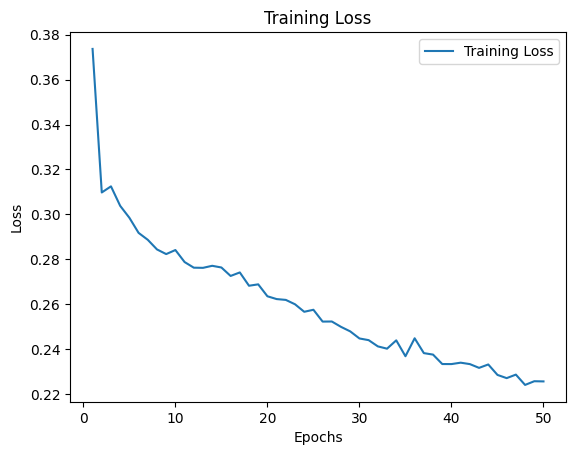


Testing Start -----------------------

Dice: 0.08130887150764465	F1: 0.0012919499215601833
Dice: 0.49438202381134033	F1: 0.00040638016864777
Dice: 0.4749978184700012	F1: 0.003965303593556382
Dice: 0.7915840744972229	F1: 0.0007763975155279503
Dice: 0.15255840122699738	F1: 0.01901490226437004
Dice: 0.1960386484861374	F1: 0.007275068404957347
Dice: 3.8875713759267683e-10	F1: 0.005128022506321
Dice: 3.1786393517307943e-09	F1: 0.0
Dice: 4.5495904821279964e-09	F1: 0.0
Dice: 4.861684943513467e-10	F1: 0.004706087411216175
Dice: 0.18290749192237854	F1: 0.0069151627593186035
Dice: 0.5404691696166992	F1: 0.0048543689320388345
Dice: 0.2669261395931244	F1: 0.05479554180489805
Dice: 0.2887023687362671	F1: 0.0007520754389517226
Dice: 0.0692262053489685	F1: 0.01274403470715835
Dice: 0.5064264535903931	F1: 0.05274562000866712
Dice: 0.36087268590927124	F1: 0.05535116138597551
Dice: 1.8378973898336426e-09	F1: 0.0
Dice: 0.15146824717521667	F1: 0.012110056190660724
Dice: 0.006937162950634956	F1: 0.1739939

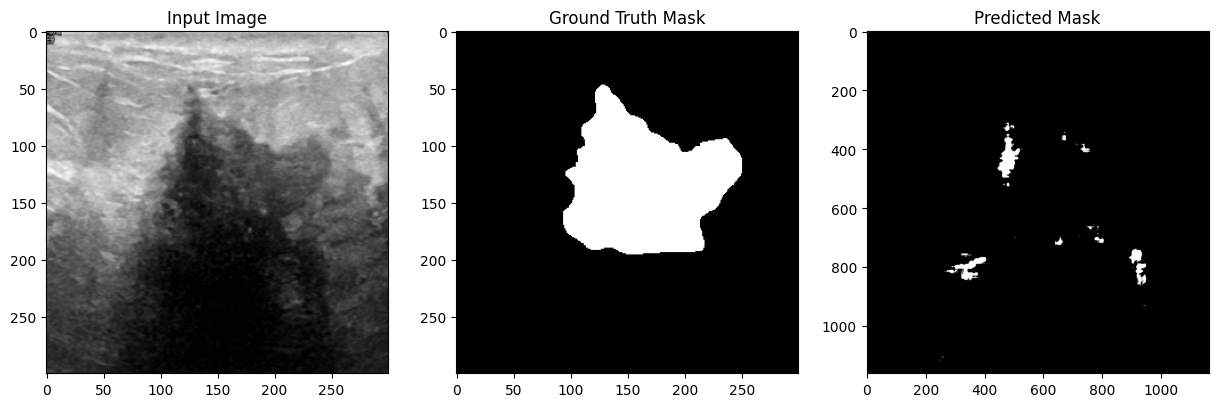

In [28]:
plt.plot(range(1, num_epoch + 1), train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()
def iou(model_output, mask) :
    smooth = 1e-5
    model_output = F.interpolate(model_output, size=(mask.size(1), mask.size(2)), mode = 'nearest')
    image = (model_output.squeeze(1) > 0.5).bool()
    mask = (mask.squeeze(1) > 0.5).bool()
    intersect = torch.sum(image*mask)
    union = torch.sum(image) + torch.sum(mask)
    return (2. * intersect + smooth) / (union + smooth)

def f1(model_output, mask):
    model_output = (model_output.squeeze(1) > 0.5).bool()
    mask = (mask.squeeze(1) > 0.5).bool()
    model_output = model_output.view(-1).cpu().numpy()
    mask = mask.view(-1).cpu().numpy()
    fin = f1_score(mask, model_output)
    return fin

def test(model, device, test_loader) :
    model.eval()
    total_iou = 0.0
    total_f1 = 0.0
    num_test = 0

    with torch.no_grad() :
        for image, mask in test_loader :
            image, mask = image.to(device), mask.to(device)
            output = model(image)
            threshold = torch.sigmoid(output)
            threshold = (threshold > 0.5).float()
            cur_iou = iou(image, mask)
            cur_f1 = f1(image, mask)
            print(f"Dice: {cur_iou}\tF1: {cur_f1}")
            total_iou += cur_iou
            total_f1 += cur_f1
            num_test += 1

    print('\nTest set: Average dice: {:.4f} Average f1: {:.4f} Within {} tests\n'.format(
        total_iou/len(test_loader.dataset), total_f1/len(test_loader.dataset), num_test))

print("\nTesting Start -----------------------\n")
test(model, device, test_loader)

with torch.no_grad():
    for image, mask in test_loader:
        image, mask = image.to(device), mask.to(device)
        print(f"Dice: {iou(mask, mask)}")

        output = model(image)

        image = image[0].cpu().numpy().squeeze()
        mask = mask[0].cpu().numpy().squeeze()
        output = torch.sigmoid(output[0])
        output = (output > 0.5).float().cpu().numpy().squeeze()

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title('Input Image')
        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title('Ground Truth Mask')
        ax[2].imshow(output, cmap='gray')
        ax[2].set_title('Predicted Mask')

        plt.show()

        break